# strategies for multi classification
1) one-versus-the-rest (OvR) strategy (also called oneversus-all):
system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers. 
select the class whose classifier outputs the highest score.

2) one-versus-one (OvO) strategy:
train a binary classifier for every pair of digits: one
to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.got their decision scores for the image, and selected the class that won the most duels.


In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

X,y= mnist['data'] , mnist['target']
X.shape,y.shape

((70000, 784), (70000,))

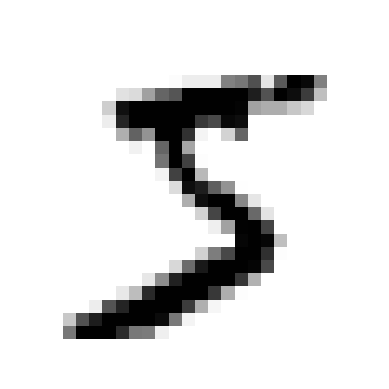

In [11]:
X = mnist['data'].to_numpy()
y = mnist['target'].to_numpy()


import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()


In [12]:
#split train and test sets
import numpy as np
y = y.astype(np.uint8)

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]


In [9]:
#OvO strategy used by sklearn
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [10]:
# save svc model
import joblib
joblib.dump(svm_clf,'svm_clf.pkl')

['svm_clf.pkl']

In [14]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
#highest score is of 5
np.argmax(some_digit_scores)
svm_clf.classes_ #show classes
svm_clf.classes_[5]

5

# If you want to force Scikit-Learn to use one-versus-one or one-versus-therest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. 

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

In [ ]:
joblib.dump(ovr_clf,'ovr_clf')
len(ovr_clf.estimators_)

In [14]:
#training a sgd clf
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier().fit(X_train,y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [16]:
sgd_clf.decision_function([some_digit])

array([[-13734.55017322, -33212.62428305,  -9069.91910049,
          -836.32912583, -20944.32771063,  -1688.64547298,
        -23420.29559535, -10492.60016413, -11831.64885884,
        -11468.15808019]])

In [17]:
#evaluate sgd
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train,
                cv=3, scoring='accuracy')

array([0.8754 , 0.87815, 0.85005])

In [19]:
# scaling it & Evaluating again
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,
                X_train_scaled,
                y_train,
                cv=3,
                scoring='accuracy')

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9026, 0.8904, 0.903 ])

In [20]:
#Error Analysis

# 1) Confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,
                                 y_train,cv=3)
cm = confusion_matrix(y_train,y_train_pred)
cm

array([[5718,    1,   35,   14,   10,   24,   39,    4,   64,   14],
       [   2, 6380,   98,   28,   11,   38,   17,   15,  142,   11],
       [ 112,   47, 5095,  144,   67,   29,  110,   72,  264,   18],
       [  45,   21,  234, 5069,   17,  287,   38,   75,  275,   70],
       [  24,   26,   68,   14, 5127,   21,   51,   60,  189,  262],
       [ 110,   15,   62,  214,   71, 4323,  169,   28,  340,   89],
       [  67,   12,   61,    8,   85,  100, 5503,    2,   78,    2],
       [  34,   17,   85,   38,   86,   21,    5, 5744,   72,  163],
       [  52,   70,  127,  128,   37,  357,   55,   40, 4908,   77],
       [  48,   19,   32,  102,  281,  128,    4,  496,  301, 4538]],
      dtype=int64)

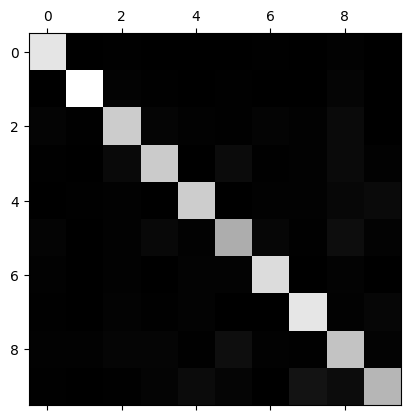

In [21]:
#image of cm
plt.matshow(cm,cmap=plt.cm.gray)
plt.show()

# insights about cm above
1) lighter colour: higher values
darker colour: lower values 

2) Rows: true labels & cols: predicted labels

3) main diagonal elements: correct predictions

4) off-diagonal elements repr misscalssifications 

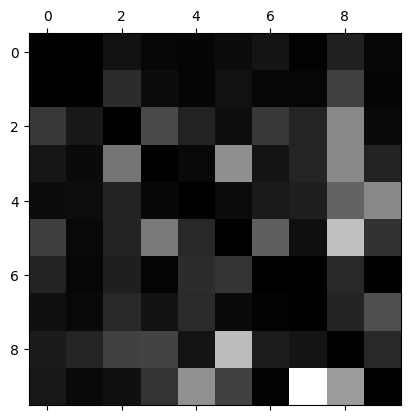

In [22]:
#solve error rate from absolute values
rows_sums = cm.sum(axis=1,keepdims=True)
norm_cm = cm / rows_sums

#fill the diagonal with zeroes to keep only the errors
np.fill_diagonal(norm_cm,0)
plt.matshow(norm_cm,cmap=plt.cm.gray)
plt.show()

# insights:
1) 8 col (predicted 8's) have more lighter colors implies more misclassified 8's
2) 8 row (actual 8's) have less lighter colors implies
more actual 8's are classified as 8's
3) we should increase precision while trading with recall
by either collecting images of not-8

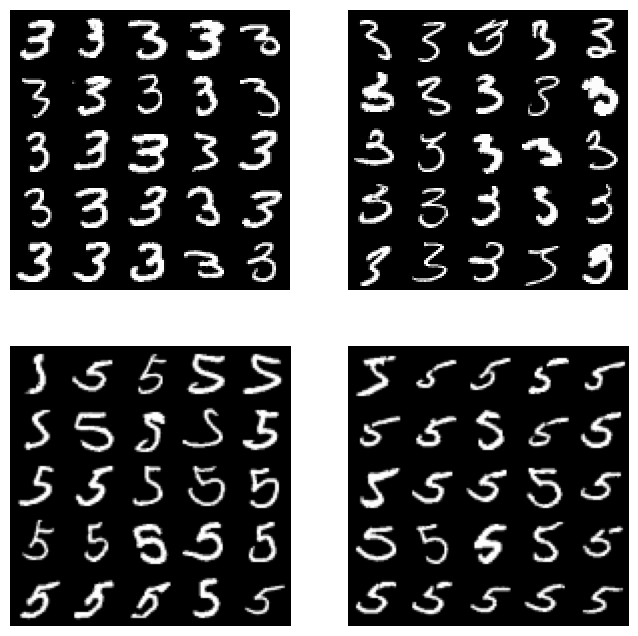

In [26]:
#Analyzing Individual errors
def plot_digits(instances, images_per_row=5):
    size = 28  # MNIST images are 28x28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    for row in range(n_rows):
        rimages = images[row * images_per_row:(row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='gray')
    plt.axis("off")

cl_a,cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5)
plt.show()



# insights
1) The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right show images classified as 5s.

2) most misclassified images seem like obvious
errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple SGDClassifier, which is a linear model.